# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset file of current TKL

In [3]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_min_5,y_pct_5,y_mean_22,NASDAQ,Oil,NASDAQ_max_65,y_min_22,y,y_diff_10,y_std_5,y_diff_5,y_min_65,Gold,y_diff_22
4821,2025-12-05,0.970774,0.973908,-0.000253,0.95812,0.983237,0.534168,1.0,0.929787,0.973908,0.044121,0.010227,-0.000247,0.790067,0.96719,0.031696



df for visualization
----------------------


,Date,y_min_5_orig,y_pct_5_orig,y_mean_22_orig,NASDAQ_orig,Oil_orig,NASDAQ_max_65_orig,y_min_22_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_diff_5_orig,y_min_65_orig,Gold_orig,y_diff_22_orig,y_next_orig
4821,2025-12-05,278.779999,-0.000251,274.296233,23578.130859,60.080002,23958.470703,266.25,278.779999,12.529999,2.90438,-0.070007,226.570358,4212.899902,9.001526,277.890015


# Data prep

In [4]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.9 * len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

In [5]:
def train_predict(X_train, X_test, y_train, y_test, features, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'Parallel.LSTM.GRU':
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm_branch = LSTM(units=50, return_sequences=False)(input_layer)
    gru_branch = GRU(units=50, return_sequences=False)(input_layer)
    merged = Concatenate()([lstm_branch, gru_branch])
    dropout = Dropout(0.1, name='dropout_layer')(merged)
    output_layer = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input_layer, outputs=output_layer)

  if model_name == 'Cascase.CNN.GRU':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'Cascase.CNN.LSTM':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'CNN':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
  ])

  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
  ])

  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  print("=====================================================================")
  print(f"Model: {model_name}")
  print(f"Neatures: {features}")
  model.summary()

  #history = model.fit(X_train, y_train,
  history = model.fit(X_train, y_train,
                      epochs=int(project_config['TRAIN_EPOCS']),
                      batch_size=int(project_config['TRAIN_BATCH_SIZE']),
                      validation_data=(X_test, y_test),
                      verbose=1)

  pred = model.predict(X_test)

  # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
  # This allows us to manually inverse transform the single predicted value.
  min_y_next_orig = df_orig['y_next_orig'].min()
  max_y_next_orig = df_orig['y_next_orig'].max()

  # Inverse transform the scaled prediction using the min-max formula
  unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
  unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)
  print(f"MAE: {mae:.4f}")

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [6]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

# **Racing Models:**
# LSTM, GRU, CNN, Cascade CNN LSTM, Cascade CNN GRU, Parallel LSTM GRU

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

  X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Parallel.LSTM.GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "Parallel.LSTM.GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "Cascase.CNN.GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.LSTM")
  results_df.loc[len(results_df)] = {
    "model_name": "Cascase.CNN.LSTM",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="CNN")
  results_df.loc[len(results_df)] = {
    "model_name": "CNN",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="LSTM")
  results_df.loc[len(results_df)] = {
    "model_name": "LSTM",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

Model: Parallel.LSTM.GRU
Neatures: ['y_min_5', 'y_pct_5', 'y_mean_22', 'NASDAQ', 'Oil', 'NASDAQ_max_65', 'y_min_22', 'y', 'y_diff_10', 'y_std_5', 'y_diff_5', 'y_min_65', 'Gold', 'y_diff_22']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 66, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     13,000 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50)        │      9,900 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,001 (89.85 KB)

 Trainable params: 23,001 (89.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0543 - val_loss: 0.0078
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 6.8909e-04 - val_loss: 0.0061
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 3.8387e-04 - val_loss: 0.0059
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 2.9164e-04 - val_loss: 0.0067
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 2.3681e-04 - val_loss: 0.0071
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 2.1907e-04 - val_loss: 0.0094
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 1.7684e-04 - val_loss: 0.0079
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.7183e-04 - val_loss: 0.0086
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 1.6579e-04 - val_loss: 0.0122
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 1.5594e-04 - val_loss: 0.0095
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 1.3184e-04 - val_loss: 0.010

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,053 (105.68 KB)

 Trainable params: 27,053 (105.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1.1721e-04 - val_loss: 0.0013
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.0947e-05 - val_loss: 0.0011
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.5906e-05 - val_loss: 0.0011
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 7.0482e-05 - val_loss: 0.0016
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.3867e-05 - val_loss: 0.0014
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.2686e-05 - val_loss: 0.0014
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 7.3383e-05 - val_loss: 8.1656e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 8.9657e-05 - val_loss: 0.0011
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.0526e-05 - val_loss: 7.8480e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 7.2847e-05 - val_loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,657 (858.04 KB)

 Trainable params: 219,657 (858.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0074 - val_loss: 0.0084
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.9771e-04 - val_loss: 0.0026
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0010 - val_loss: 0.0101
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.7786e-04 - val_loss: 0.0011
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.4396e-04 - val_loss: 0.0034
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 12/20
134/134 ━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 66, 50)         │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,771 (45.98 KB)

 Trainable params: 11,771 (45.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0418 - val_loss: 0.0016
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - loss: 1.0838e-04 - val_loss: 0.0012
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 7.1791e-05 - val_loss: 9.8953e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 6.0246e-05 - val_loss: 0.0013
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 5.1649e-05 - val_loss: 0.0012
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 5.9212e-05 - val_loss: 0.0012
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 6.6819e-05 - val_loss: 0.0022
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 6.7222e-05 - val_loss: 0.0014
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 5.6442e-05 - val_loss: 0.0010
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 5.8763e-05 - val_loss: 0.0015
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 5.5853e-05 - val_

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 66, 50)         │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,451 (60.36 KB)

 Trainable params: 15,451 (60.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 0.0204 - val_loss: 0.0054
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 1.2266e-04 - val_loss: 0.0047
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.7409e-05 - val_loss: 0.0056
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.5917e-05 - val_loss: 0.0064
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 7.7002e-05 - val_loss: 0.0034
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 8.2717e-05 - val_loss: 0.0047
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 6.9735e-05 - val_loss: 0.0035
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 6.8606e-05 - val_loss: 0.0040
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 7.0491e-05 - val_loss: 0.0034
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 6.8586e-05 - val_loss: 0.0030
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 7.5588e-05 - val_loss: 0.0036


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 66, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 50)        │     11,000 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 50)        │      8,400 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,501 (76.18 KB)

 Trainable params: 19,501 (76.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0531 - val_loss: 0.0098
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 7.9178e-04 - val_loss: 0.0060
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.9531e-04 - val_loss: 0.0066
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 3.3426e-04 - val_loss: 0.0061
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 2.7720e-04 - val_loss: 0.0063
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 2.7322e-04 - val_loss: 0.0069
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 2.5083e-04 - val_loss: 0.0055
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 1.7647e-04 - val_loss: 0.0058
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1.9599e-04 - val_loss: 0.0060
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 1.7411e-04 - val_loss: 0.0053
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.7251e-04 - val_loss: 0.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 64, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,133 (98.18 KB)

 Trainable params: 25,133 (98.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0206 - val_loss: 0.0037
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.5084e-04 - val_loss: 0.0042
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.0602e-04 - val_loss: 0.0039
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.6515e-04 - val_loss: 0.0030
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.5303e-04 - val_loss: 0.0019
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.4482e-04 - val_loss: 0.0020
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.4044e-04 - val_loss: 0.0021
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 1.2212e-04 - val_loss: 0.0011
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.1917e-04 - val_loss: 0.0028
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.3590e-04 - val_loss: 0.0019
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.0933e-04 - val_loss: 0.0026
E

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 64, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,737 (850.54 KB)

 Trainable params: 217,737 (850.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0108 - val_loss: 0.0038
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0010 - val_loss: 0.0081
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.9189e-04 - val_loss: 0.0026
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.5106e-04 - val_loss: 0.0019
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.0780e-04 - val_loss: 0.0013
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.0753e-04 - val_loss: 0.0023
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.7826e-04 - val_loss: 0.0014
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.2231e-04 - val_loss: 0.0014
Epoch 12/20
134/1

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 66, 50)         │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,271 (40.12 KB)

 Trainable params: 10,271 (40.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0234 - val_loss: 0.0015
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 2.0980e-04 - val_loss: 0.0012
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 8.8482e-05 - val_loss: 9.4946e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 8.2501e-05 - val_loss: 7.5010e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 6.6037e-05 - val_loss: 7.9468e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 5.6664e-05 - val_loss: 8.1508e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 5.6845e-05 - val_loss: 6.2287e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 5.4354e-05 - val_loss: 6.4940e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 5.6213e-05 - val_loss: 7.4958e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 5.7634e-05 - val_loss: 6.6155e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/st

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 66, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0151 - val_loss: 0.0018
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.8934e-04 - val_loss: 0.0018
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.6850e-04 - val_loss: 0.0017
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.5026e-04 - val_loss: 0.0015
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 1.5531e-04 - val_loss: 0.0014
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.5975e-04 - val_loss: 0.0017
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 1.5831e-04 - val_loss: 0.0013
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1.2866e-04 - val_loss: 0.0012
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.3434e-04 - val_loss: 0.0012
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.3526e-04 - val_loss: 0.0018
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.2943e-04 - val_loss: 0.0011

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 66, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 50)        │     10,400 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 50)        │      7,950 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │                   │            │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,451 (72.07 KB)

 Trainable params: 18,451 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 0.0668 - val_loss: 0.0094
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 3.3913e-04 - val_loss: 0.0058
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 2.5859e-04 - val_loss: 0.0070
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 2.4743e-04 - val_loss: 0.0059
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 2.1159e-04 - val_loss: 0.0056
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 1.9904e-04 - val_loss: 0.0066
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 2.0620e-04 - val_loss: 0.0046
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 2.0099e-04 - val_loss: 0.0045
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 1.7726e-04 - val_loss: 0.0053
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 2.0101e-04 - val_loss: 0.0052
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 1.8562e-04 - val_loss: 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,557 (95.93 KB)

 Trainable params: 24,557 (95.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.6937e-04 - val_loss: 0.0027
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.7275e-04 - val_loss: 0.0018
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.5207e-04 - val_loss: 0.0022
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.2497e-04 - val_loss: 0.0028
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.2623e-04 - val_loss: 0.0010
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.1149e-04 - val_loss: 0.0013
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.0889e-04 - val_loss: 8.7336e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.0536e-04 - val_loss: 0.0010
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.0416e-04 - val_loss: 9.0614e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.0524e-04 - val_loss: 

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,161 (848.29 KB)

 Trainable params: 217,161 (848.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.9705e-04 - val_loss: 0.0212
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.0489e-04 - val_loss: 0.0017
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.1415e-04 - val_loss: 0.0056
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.0959e-04 - val_loss: 0.0019
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.9625e-04 - val_loss: 0.0022
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.7323e-04 - val_loss: 0.0018
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.3150e-04 - val_loss: 0.0012
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.7963e-04 - val_loss: 0.0016
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.1365e-04 - val_loss: 0.0123
Epoch

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 66, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,821 (38.36 KB)

 Trainable params: 9,821 (38.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.0164 - val_loss: 8.3508e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 6.8400e-05 - val_loss: 8.0664e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 6.4918e-05 - val_loss: 7.7427e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 6.3313e-05 - val_loss: 7.2480e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 5.8871e-05 - val_loss: 6.3798e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 6.0438e-05 - val_loss: 5.6306e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 6.5144e-05 - val_loss: 5.7270e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 6.1756e-05 - val_loss: 5.2817e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 5.3427e-05 - val_loss: 4.9547e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 5.4263e-05 - val_loss: 5.0647e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 66, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0095 - val_loss: 0.0022
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 1.7115e-04 - val_loss: 0.0035
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1.5896e-04 - val_loss: 0.0032
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 1.2487e-04 - val_loss: 0.0024
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.3608e-04 - val_loss: 0.0026
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.2402e-04 - val_loss: 0.0021
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.3286e-04 - val_loss: 0.0020
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 1.0725e-04 - val_loss: 0.0017
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.0903e-04 - val_loss: 0.0010
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 1.0824e-04 - val_loss: 0.0015
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 1.2332e-04 - val_loss: 0.00

In [9]:
def plot_results(results_df):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(10,6))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=3)

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(10,6))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=3)

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

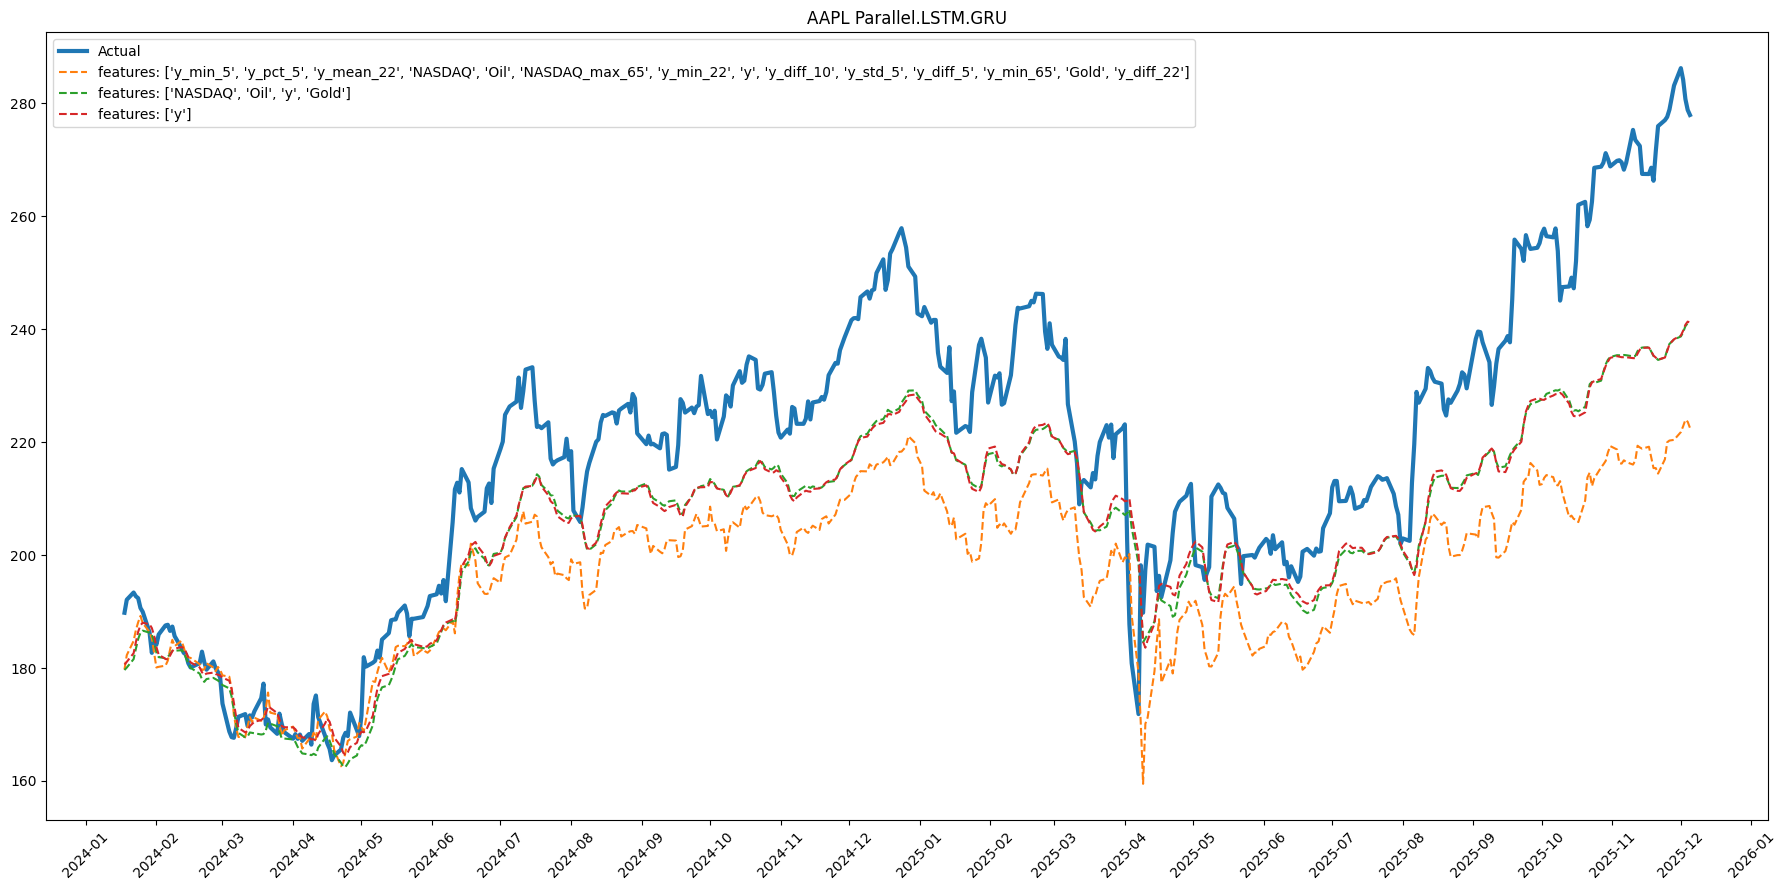

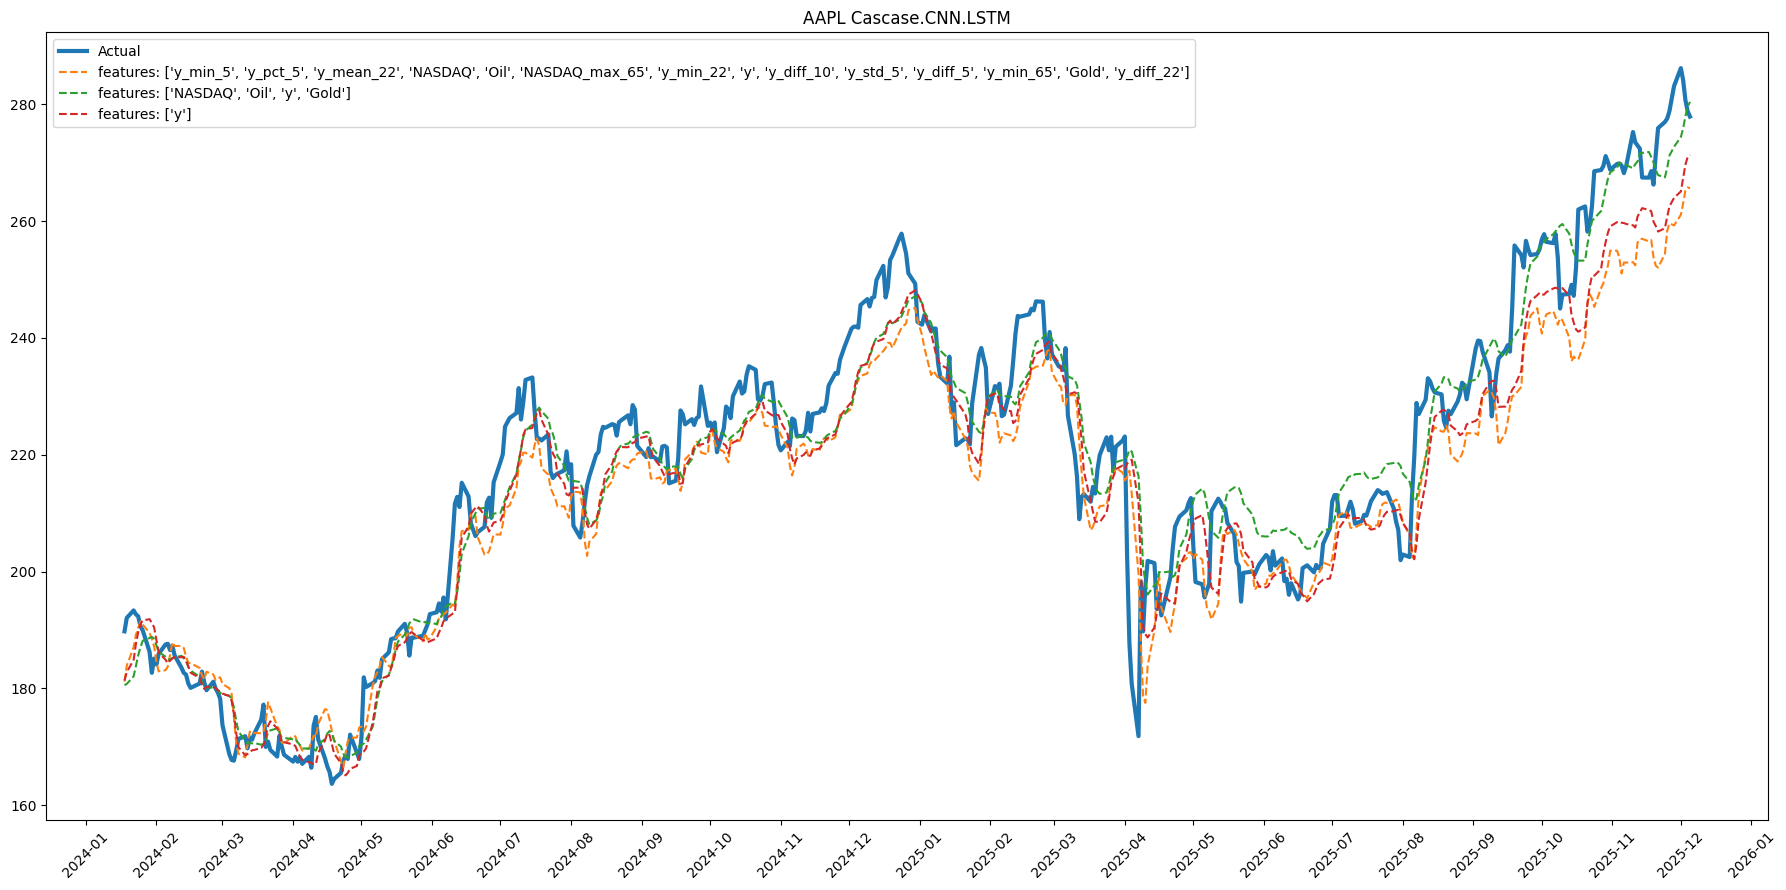

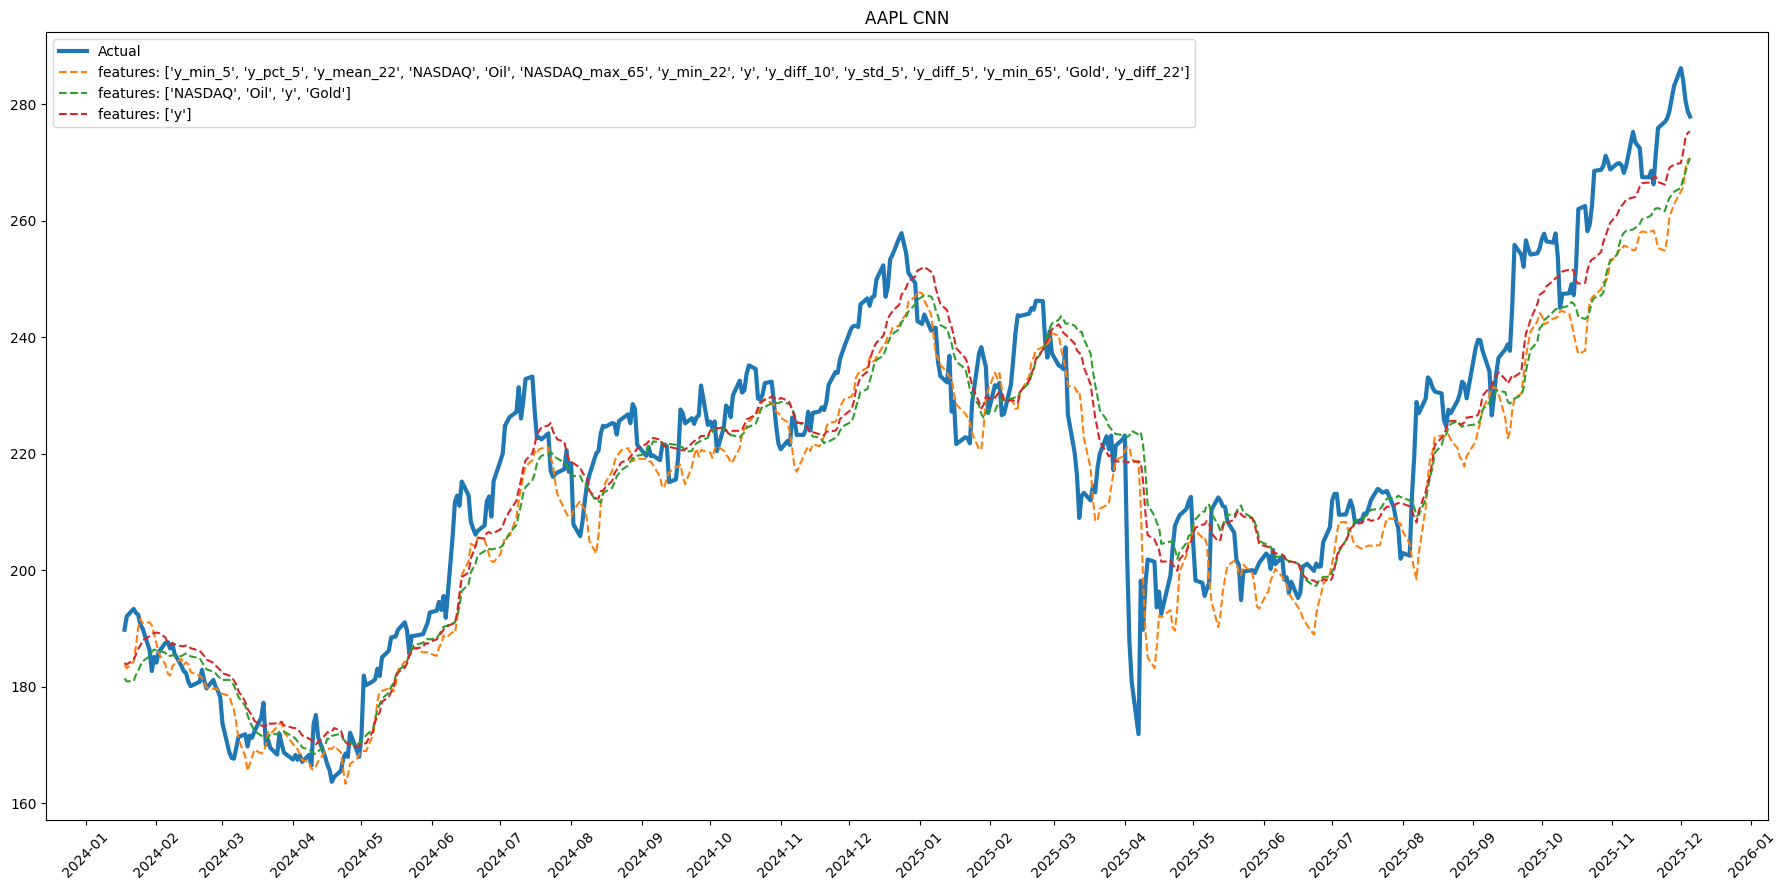

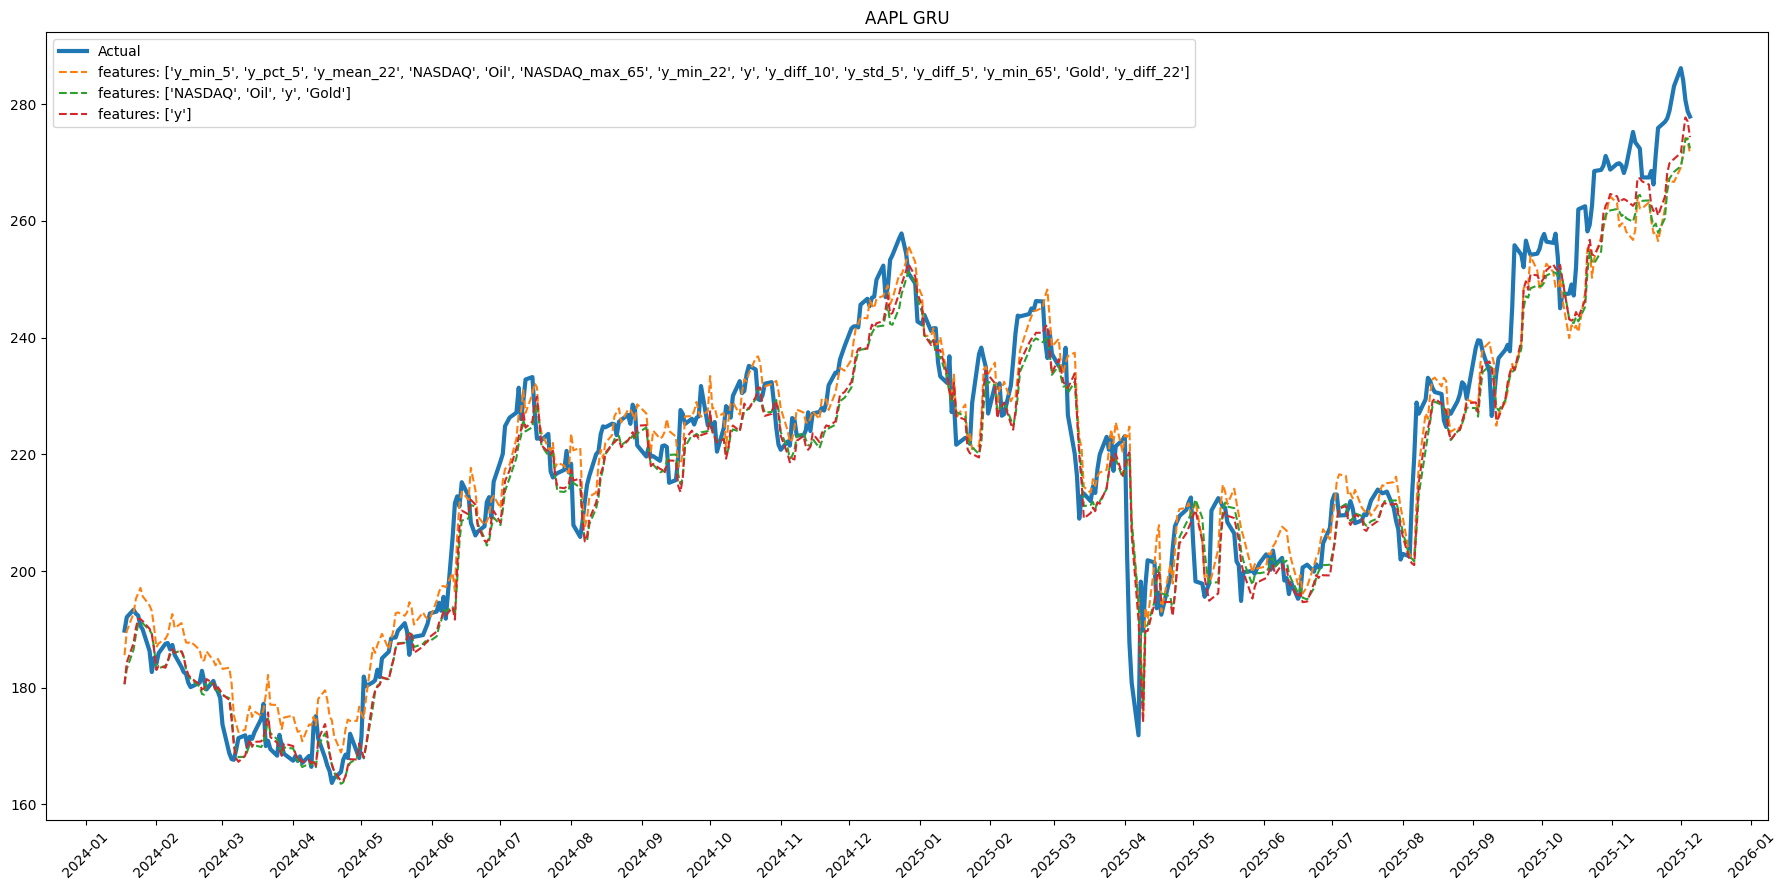

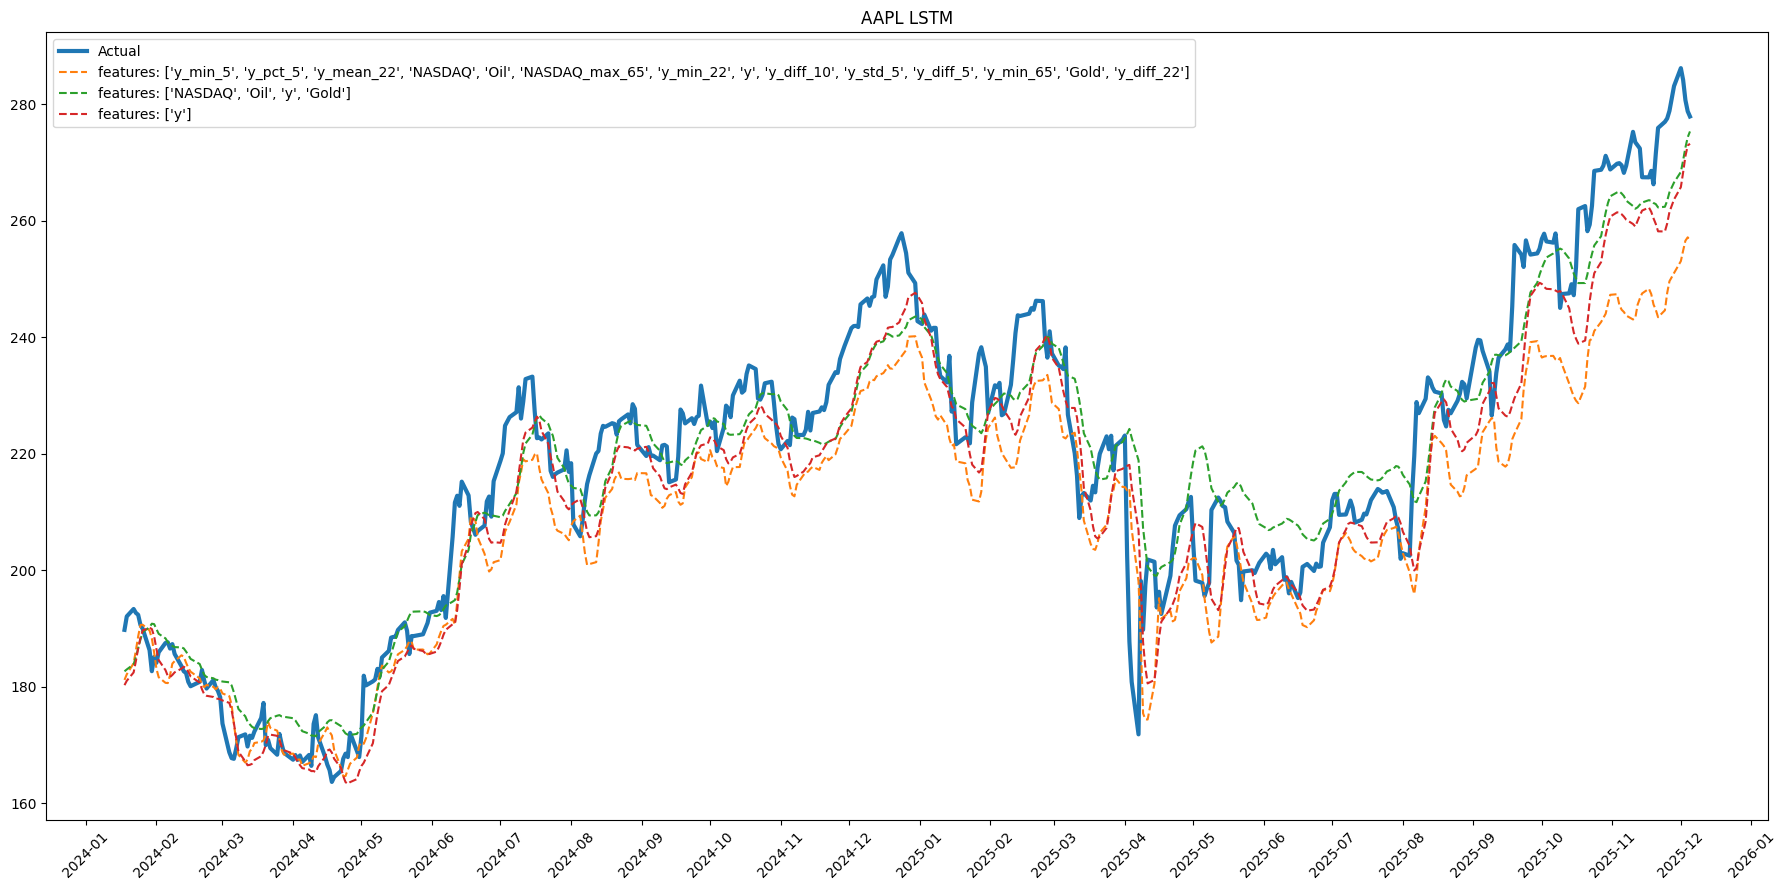

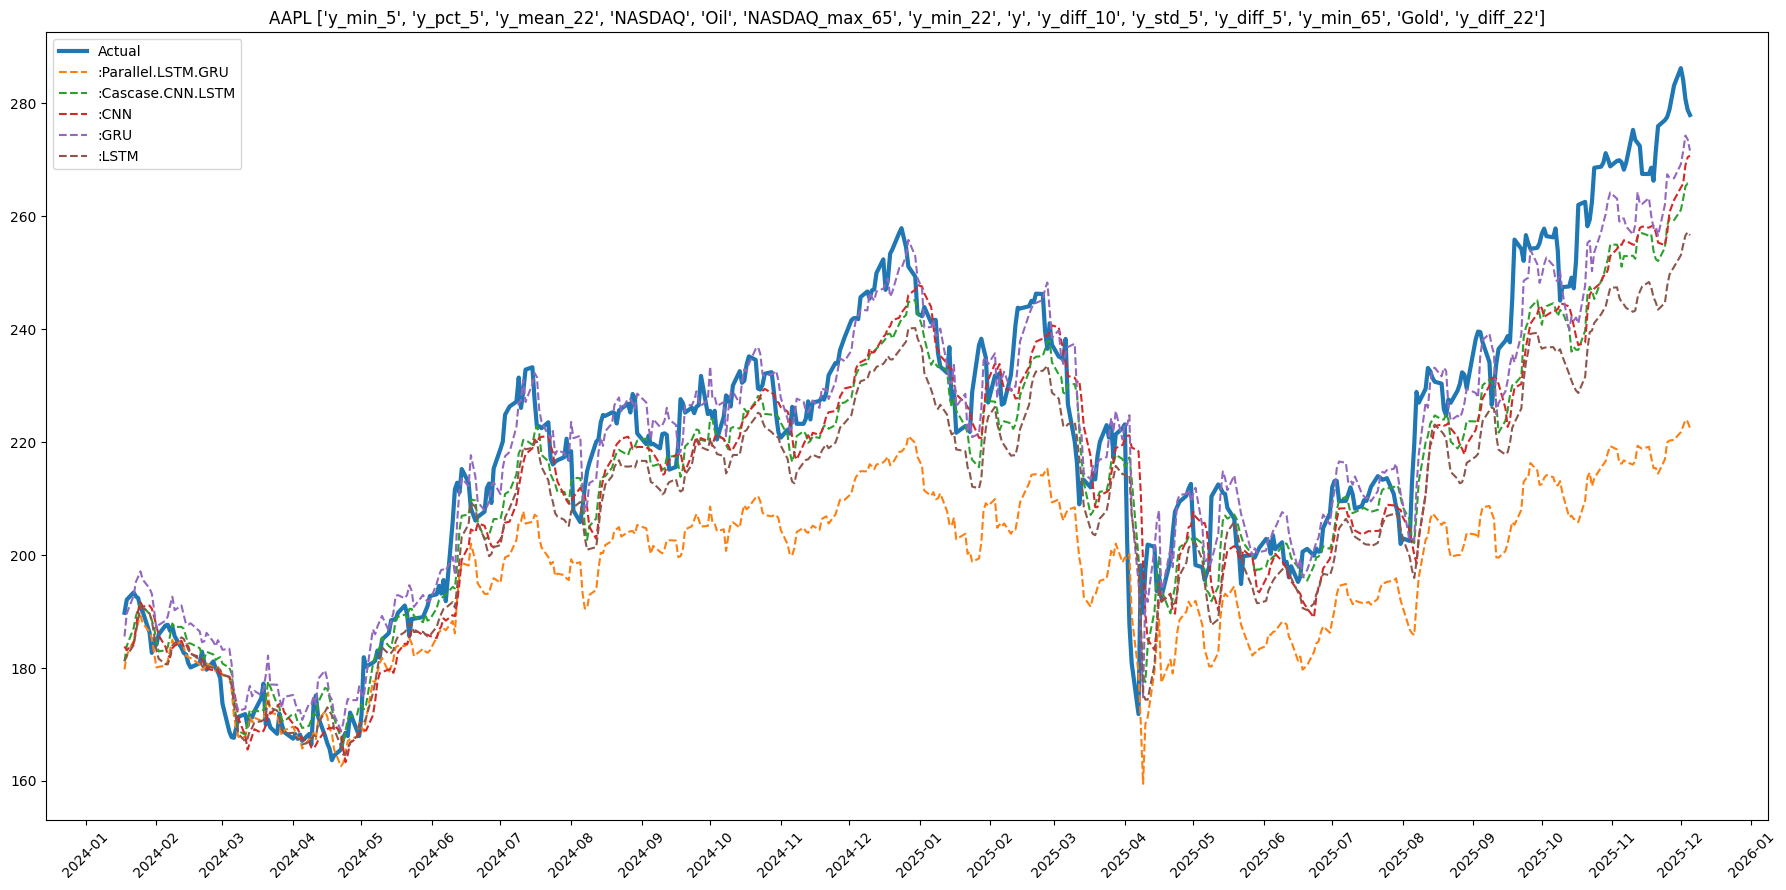

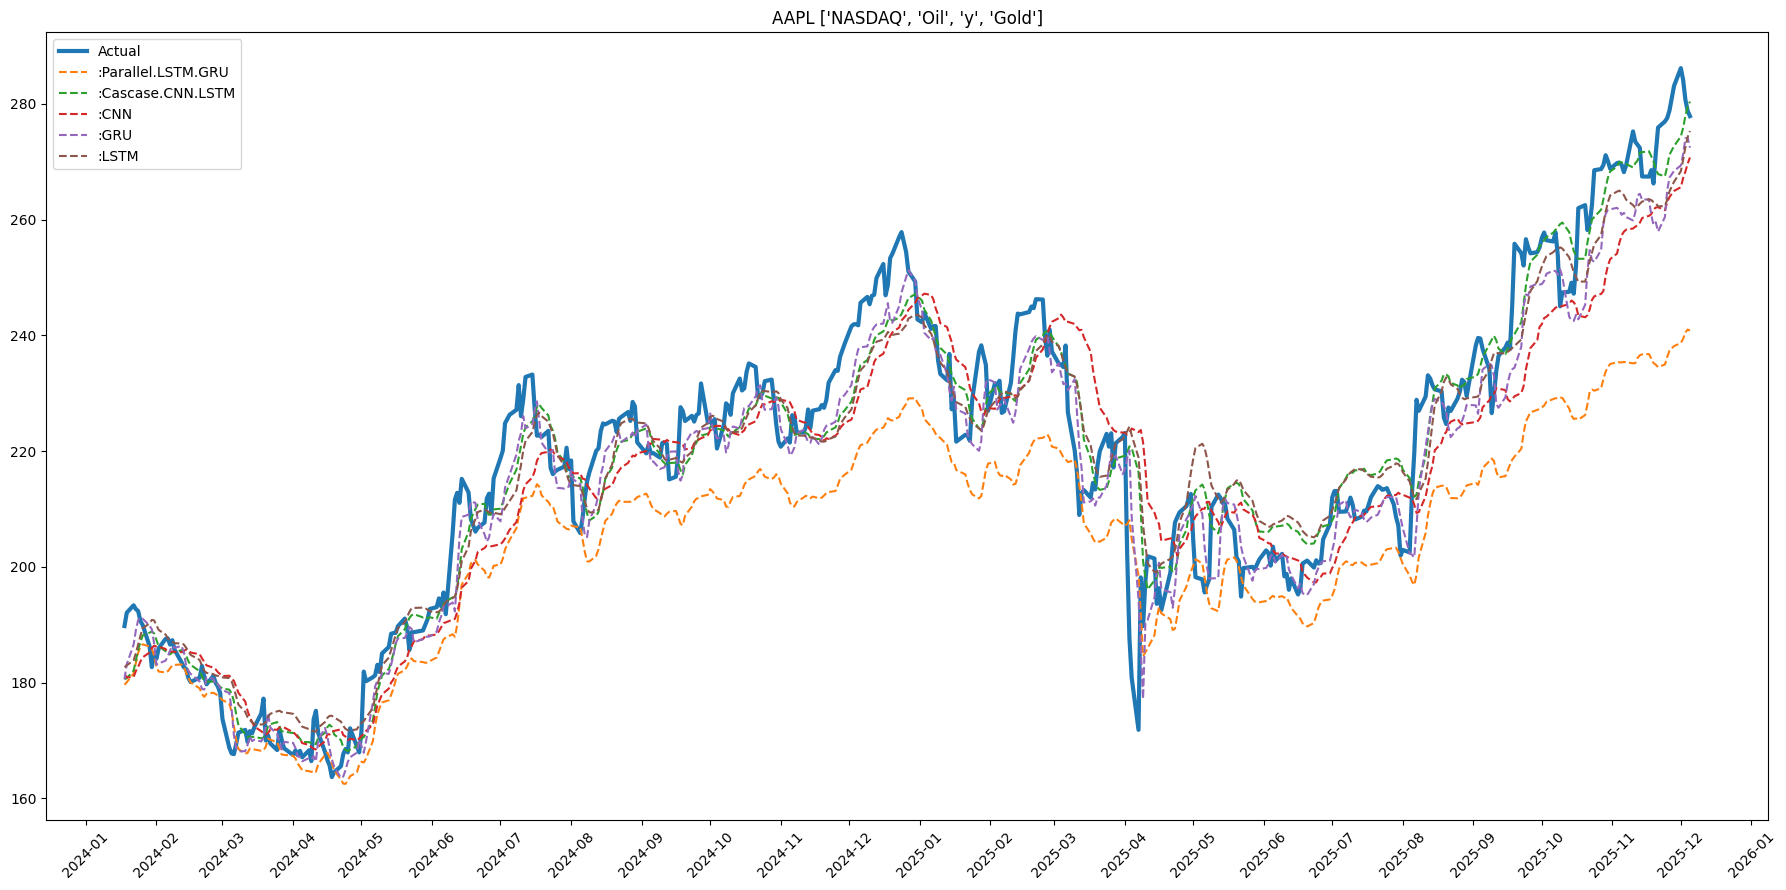

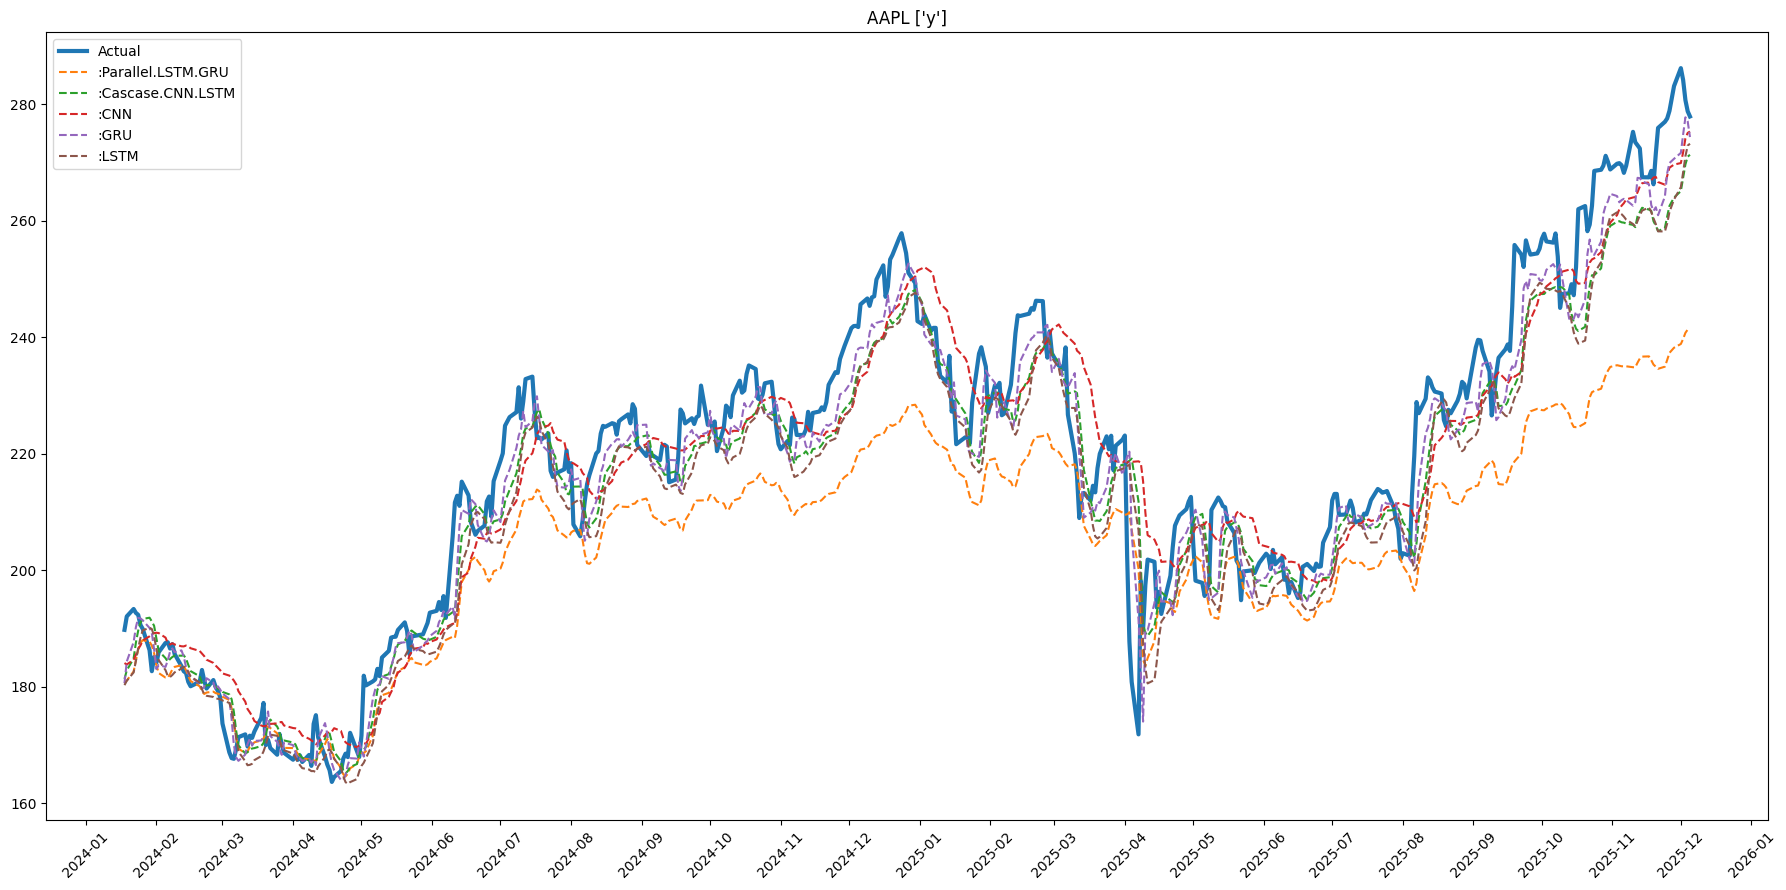

In [10]:
plot_results(results_df)

In [11]:
print(f"AND THE WINNER for {project_config['TKL']} IS ...")
results_df.sort_values(by='mae', ascending=True).iloc[0]

AND THE WINNER for AAPL IS ...


,13
model_name,GRU
X_cols,[y]
prediction,"[[180.621], [184.34735], [187.6768], [190.2353..."
mae,4.964034
r2,0.944294
model,"<Sequential name=sequential_10, built=True>"
X_cols_tuple,"(y,)"


In [12]:
winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.keras"
winning_model.save(model_path)